# Potato Disease Classification

In [ ]:
import numpy as np
import os
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [19]:
INIT_LR = 1e-3
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "Potato"
AUTOTUNE = tf.data.AUTOTUNE

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


In [22]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


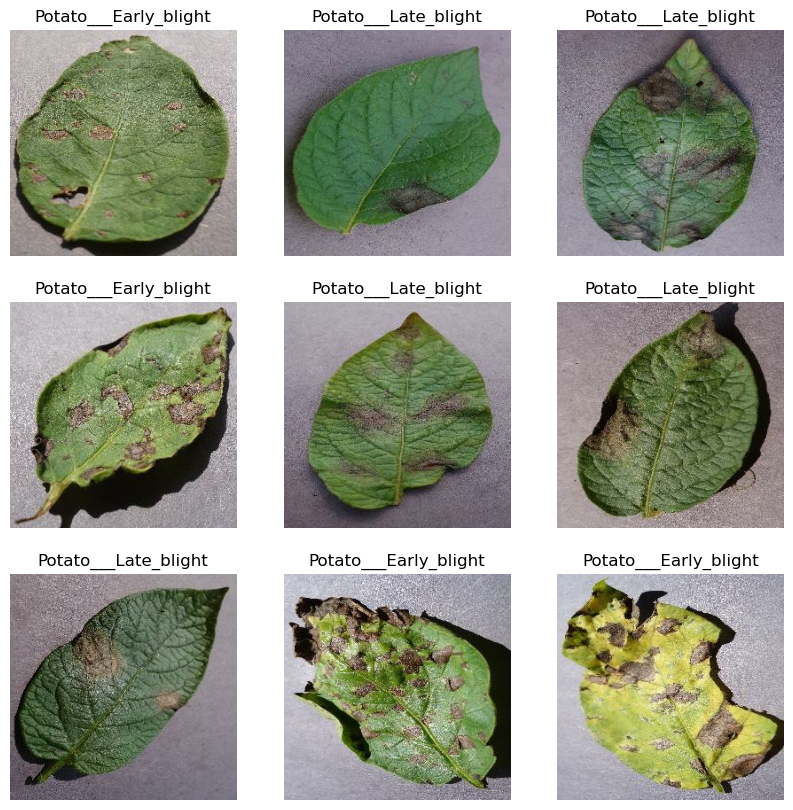

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [25]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)   
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [30]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [31]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_5 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (32, 60, 60, 64)         

In [32]:
optimizer = "adam"
model.compile(
    optimizer = optimizer,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [33]:

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    verbose = 1,
    batch_size = BATCH_SIZE
)

Epoch 1/20
54/54 [==============================] - 43s 757ms/step - loss: 0.8808 - accuracy: 0.5246 - val_loss: 0.7061 - val_accuracy: 0.7135
Epoch 2/20
54/54 [==============================] - 38s 711ms/step - loss: 0.6153 - accuracy: 0.7353 - val_loss: 0.4417 - val_accuracy: 0.8333
Epoch 3/20
54/54 [==============================] - 38s 697ms/step - loss: 0.4061 - accuracy: 0.8263 - val_loss: 0.2422 - val_accuracy: 0.9323
Epoch 4/20
54/54 [==============================] - 39s 717ms/step - loss: 0.3314 - accuracy: 0.8662 - val_loss: 0.2191 - val_accuracy: 0.9010
Epoch 5/20
54/54 [==============================] - 41s 764ms/step - loss: 0.2593 - accuracy: 0.9014 - val_loss: 0.2128 - val_accuracy: 0.9271
Epoch 6/20
54/54 [==============================] - 44s 812ms/step - loss: 0.1318 - accuracy: 0.9531 - val_loss: 0.2988 - val_accuracy: 0.9010
Epoch 7/20
54/54 [==============================] - 40s 735ms/step - loss: 0.1449 - accuracy: 0.9425 - val_loss: 0.1214 - val_accuracy: 0.9427

In [34]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 161ms/step - loss: 0.0731 - accuracy: 0.9727
Test Accuracy: 97.27%


In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

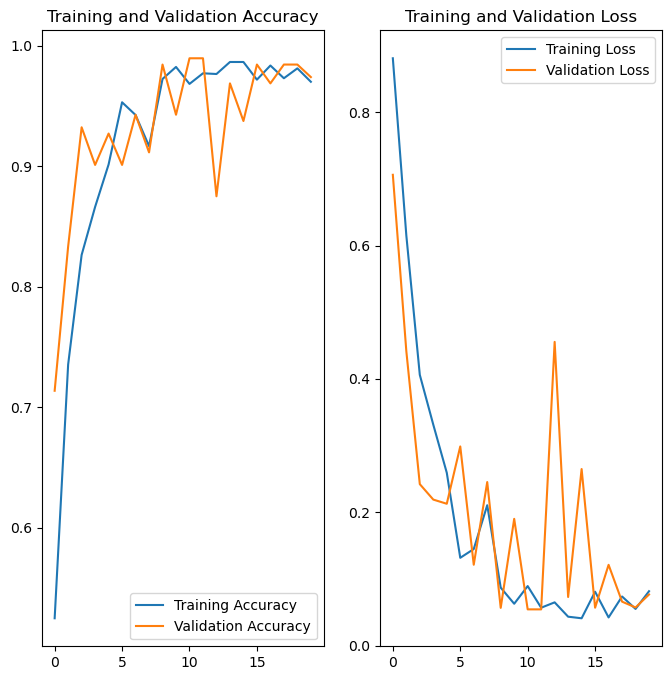

In [36]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
model_version = max([int(i) for i in os.listdir("../models")]) + 1
model.save(f"../models/{model_version}/model.h5")

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

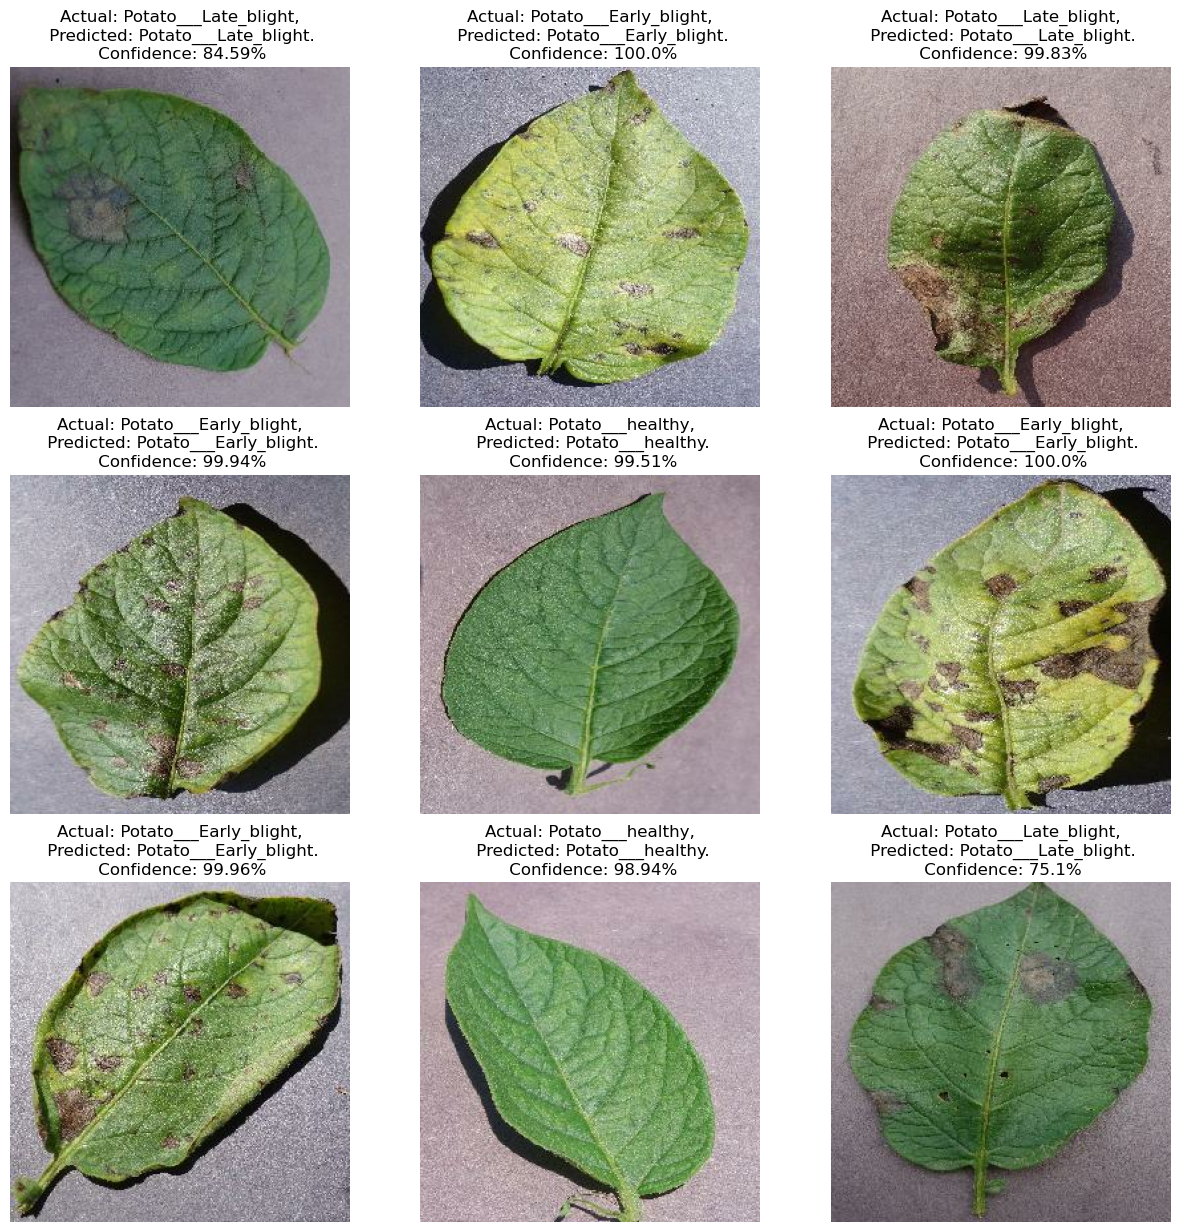

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
